In [1]:
# The code for this notebook and imported files are based of this repository: https://github.com/few-shot-NER-benchmark/BaselineCode
# It is recommended that you inspect the original implementation before inspecting this modified version

In [2]:
# All the imports
import os
import random
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch import nn
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import transformers
from transformers import RobertaTokenizer, RobertaForMaskedLM, RobertaModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.optim import Adam
import time
import json

import random
from collections import Counter, defaultdict
import numpy as np
from sample_few_shot import get_label_dict
from finetune_model import RobertaNER, BertNER
from eval_util import batch_span_eval
from data import *
from torch.utils.tensorboard import SummaryWriter

c:\users\athul raj nambiar\appdata\local\programs\python\python38\lib\site-packages\scipy\__init__.py:173: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.18.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Using GPU
if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is available


In [4]:
# Formatting data to be able to input it, into the model
def generate_batch(batch):
    text = [F.pad(torch.tensor(x[0]), (0,max_seq_len-len(x[0])), "constant", 1) for x in batch] # batch_size * max_seq_len 
    text = pad_sequence(text, batch_first = True)
    attention_mask = [torch.cat((torch.ones_like(torch.tensor(x[0])), torch.zeros(max_seq_len-len(x[0]), dtype=torch.int64)), dim=0)
        if len(x[0]) < max_seq_len else torch.ones_like(torch.tensor(x[0]))[:max_seq_len] for x in batch]
    attention_mask = pad_sequence(attention_mask, batch_first = True)
    label = [F.pad(torch.tensor(x[1]), (0,max_seq_len-len(x[1])), "constant", -100) for x in batch]
    label = pad_sequence(label, batch_first = True)
    orig_len = [len(x[0]) for x in batch]

    return text, attention_mask, label, orig_len


In [5]:
#  Train function to train the model using a linear classifier
def train_func(processed_training_set, epoch, tokenizer, label_sentence_dicts, soft_kmeans, count_num = 0, unsup_data_iter = None):

    # Train the model
    train_loss = 0
    total_pred, total_gold, total_crct = 0.0, 0.0, 0.0
    dataset_chosen = []
    data = []
    for i,d in enumerate(processed_training_set):
        one_dataset = DataLoader(d, batch_size=BATCH_SIZE, collate_fn=generate_batch)
        data.extend(one_dataset)
        dataset_chosen.extend([i for x in range(len(one_dataset))])
    all_data_index = [i for i in range(len(dataset_chosen))]
    print("shuffling sentences")
    random.shuffle(all_data_index)

    
    model.train()
    print(f"total {len(all_data_index)} iters")
    for k in all_data_index:
        count_num += 1
        text, attention_mask, cls, orig_len = data[k]
        id2label = id2labels[dataset_chosen[k]]
        optimizer.zero_grad()
        outputs = []
        text_1, attention_mask_1, cls_1 = text.to(device), attention_mask.to(device), cls.to(device)
        cls_2 = cls.to(device)
        loss, output = model(text_1, attention_mask=attention_mask_1, labels=cls_2, dataset = dataset_chosen[k])
        loss.mean().backward()
        train_loss += loss.mean().item()
        outputs=output
        optimizer.step()
        preds = [[id2label[int(x)] for j,x in enumerate(y[1:orig_len[i]-1]) if int(cls[i][j + 1]) != -100] for i,y in enumerate(outputs)]
        gold = [[id2label[int(x)] for x in y[1:orig_len[i]-1] if int(x) != -100] for i,y in enumerate(cls)]
    
        bpred, bgold, bcrct, _, _, _ = batch_span_eval(preds, gold)
        total_pred += bpred
        total_gold += bgold
        total_crct += bcrct

        
        if count_num%200 == 0:
            print(f"batch: {count_num}/{int(num_training_steps/N_EPOCHS)} lr: {optimizer.param_groups[0]['lr']:.9f} loss: {loss.mean().item()/BATCH_SIZE:.9f}")
            
        # Adjust the learning rate
        scheduler.step()


    microp = total_crct/total_pred if total_pred > 0 else 0
    micror = total_crct/total_gold if total_gold > 0 else 0
    microf1 = 2*microp*micror/(microp + micror) if (microp + micror) > 0 else 0

    return train_loss / train_num_data_point * BATCH_SIZE, microp, micror, microf1

In [6]:
#  Validation function to test/validate the model

def test(data_, epoch, label_sentence_dicts, soft_kmeans, test_all_data = True, finetune = False):
    val_loss = 0
    total_pred, total_gold, total_crct = 0.0, 0.0, 0.0
    total_pred_per_type, total_gold_per_type, total_crct_per_type = defaultdict(int), defaultdict(int), defaultdict(int)
    if test_all_data:
        dataset_chosen = []
        data = []
        for i,d in enumerate(data_):
            one_dataset = DataLoader(d, batch_size=64, collate_fn=generate_batch)
            data.extend(one_dataset)
            dataset_chosen.extend([i for x in range(len(one_dataset))])
    else:
        data, _ = generate_episode(data_, epoch,  EPISODE_NUM, TEST_SUP_CLS_NUM, test_id2label, label_sentence_dict, use_multipledata = False)
    idx = 0
    f1ss = []
    pss = []
    rss = []
    
    new_model = model
    new_model.eval()
    for j, (text, attention_mask, cls, orig_len) in enumerate(data): 
        id2label = id2labels[dataset_chosen[j]]
        with torch.no_grad():
            text_1, attention_mask_1, cls_1 = text.to(device), attention_mask.to(device).to(device), cls.to(device)
            # we use the same dataset for training and testing
            loss, outputs = new_model(text_1, attention_mask=attention_mask_1, labels=cls_1, dataset = dataset_chosen[j])
            val_loss += loss.mean().item()
        preds = [[id2label[int(x)] for j,x in enumerate(y[1:orig_len[i]-1]) if int(cls[i][j + 1]) != -100] for i,y in enumerate(outputs)]
        gold = [[id2label[int(x)] for x in y[1:orig_len[i]-1] if int(x) != -100] for i,y in enumerate(cls)]
        
        
        for pred in preds:
            for t,token in enumerate(pred):
                if len(token.split('I-')) == 2:
                    if t == 0:
                        pred[t] = 'O'
                        continue
                    else:
                        tag = token.split('I-')[1]
                        if len(pred[t-1]) == 1:
                            pred[t] = 'O'
                        else:
                            if tag != pred[t-1].split('-')[1]:
                                  pred[t] = 'O'  

        bpred, bgold, bcrct, pred_span_per_type, gold_span_per_type, crct_span_per_type = batch_span_eval(preds, gold)
        total_pred += bpred
        total_gold += bgold
        total_crct += bcrct
        
        for x in pred_span_per_type:
            total_pred_per_type[x] += pred_span_per_type[x]
            total_gold_per_type[x] += gold_span_per_type[x]
            total_crct_per_type[x] += crct_span_per_type[x]

    microp = total_crct/total_pred if total_pred > 0 else 0
    micror = total_crct/total_gold if total_gold > 0 else 0
    microf1 = 2*microp*micror/(microp + micror) if (microp + micror) > 0 else 0
    microp_per_type, micror_per_type, microf1_per_type = {}, {}, {}
    for x in total_pred_per_type:
        microp_per_type[x] = total_crct_per_type[x]/total_pred_per_type[x] if total_pred_per_type[x] > 0 else 0
        micror_per_type[x] = total_crct_per_type[x]/total_gold_per_type[x] if total_gold_per_type[x] > 0 else 0
        microf1_per_type[x] = 2*microp_per_type[x]*micror_per_type[x]/(microp_per_type[x]+micror_per_type[x]) if (microp_per_type[x]+micror_per_type[x]) > 0 else 0

    return val_loss / val_num_data_point * 64, microp, micror, microf1, microp_per_type, micror_per_type, microf1_per_type

In [7]:
# Class with a lot of the information that we use hyper parameters and file names
class Args:
    def __init__(self):
        i = 0
        self.datapath = 'dataset'
        self.dataset = 'custom'
        self.train_text = f'FS_train_dataset{i}.words'
        self.train_ner = f'FS_train_dataset{i}.ner'
        self.test_text = f'FS_test_dataset{i}.words'
        self.test_ner = f'FS_test_dataset{i}.ner'
        self.model_save_name = f'FS_train_dataset{i}_finetuned_model'
        self.few_shot_sets = 1
        self.unsup_text = None
        self.unsup_ner = None
        self.base_model = 'roberta'
        self.epoch = 5
        self.train_cls_num = 4
        self.test_cls_num = 18
        self.max_seq_len = 128
        self.batch_size = 8
        self.soft_kmeans = False
        self.lr = 1e-04
        self.unsup_lr = 0.5
        self.warmup_proportion = 0.1
        self.weight_decay = 0.01
        self.use_truecase = False
        self.local_rank = None
        self.use_gpu = 'cuda'
        self.data_size = ''
        self.load_model = True
        self.reinit = False
        self.load_model_name = 'pretrained_models/lc_pretrained_190.pt'
        self.load_checkpoint = False
        self.load_dataset = False
        self.train_dataset_file = None
        self.test_dataset_file = None
        self.label2ids = None
        self.id2labels = None

In [8]:
args = Args()

In [9]:
# Main function 
if __name__ == "__main__":

    total_f1_scores = []
    train_text_file = args.train_text
    train_ner_file = args.train_ner
    for round in range(args.few_shot_sets):
        if '.' not in args.train_text:
            args.train_text = train_text_file + f'_{round}.words'
            args.train_ner = train_ner_file + f'_{round}.ner'
        print(f"train text is {args.train_text}")
        datasets = args.dataset.split('_')
        print(datasets)
        train_texts = [os.path.join(args.datapath, dataset, args.train_text) for dataset in datasets]
        train_ners = [os.path.join(args.datapath, dataset, args.train_ner) for dataset in datasets]
        test_texts = [os.path.join(args.datapath, dataset, args.test_text) for dataset in datasets]
        test_ners = [os.path.join(args.datapath, dataset, args.test_ner) for dataset in datasets]

        max_seq_len = args.max_seq_len
        base_model = args.base_model

        if base_model == 'roberta':
            tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        elif base_model == 'bert':
            tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

        label2ids, id2labels = [], []
        processed_training_set, train_label_sentence_dicts, processed_val_set, val_label_sentence_dicts = [], [], [], []
        if not args.load_dataset:
            for train_text, train_ner, test_text, test_ner in zip(train_texts, train_ners, test_texts, test_ners):
                with open(train_ner, encoding='utf-8') as fner, open(train_text, encoding='utf-8') as f:
                    train_ner_tags, train_words = fner.readlines(), f.readlines()
                with open(test_ner, encoding='utf-8') as fner, open(test_text, encoding='utf-8') as f:
                    test_ner_tags, test_words = fner.readlines(), f.readlines()   
                
                # Taking the first 20% of test set for validation set
                split_index = int(len(test_ner_tags) * 0.2)
                
                val_ner_tags = test_ner_tags[:split_index]
                val_words = test_words[:split_index]
                
                
                # Creating a validation set
                validation_data_size = int(0.05 * len(train_ner_tags))  # 5% of the data size
                indexes = list(range(len(train_ner_tags)))  # Create a list of indexes

                random.shuffle(indexes)  # Shuffle the list of indexes

                validation_indexes = indexes[:validation_data_size]  # Take the first 5% as validation indexes
                training_indexes = indexes[validation_data_size:]  # The rest will be used for training

                # Now you can create the validation and training data based on the selected indexes
                val_ner_tags = [train_ner_tags[i] for i in validation_indexes]
                val_words = [train_words[i] for i in validation_indexes]
                train_ner_tags = [train_ner_tags[i] for i in training_indexes]
                train_words = [train_words[i] for i in training_indexes]
                
                label2id, id2label = get_label_dict([train_ner_tags, val_ner_tags])
                
                label2ids.append(label2id)
                id2labels.append(id2label)

                train_ner_tags, train_words, train_label_sentence_dict = process_data(train_ner_tags, train_words, tokenizer, label2id, max_seq_len,base_model=base_model,use_truecase=args.use_truecase)
                val_ner_tags, val_words, val_label_sentence_dict = process_data(val_ner_tags, val_words, tokenizer, label2id, max_seq_len,base_model=base_model,use_truecase=args.use_truecase)

                sub_train_ = [[train_words[i], train_ner_tags[i]] for i in range(len(train_ner_tags))]
                sub_valid_ = [[val_words[i], val_ner_tags[i]] for i in range(len(val_ner_tags))] 

                train_label_sentence_dicts.append(train_label_sentence_dict)
                val_label_sentence_dicts.append(val_label_sentence_dict)

                processed_training_set.append(sub_train_) 
                processed_val_set.append(sub_valid_) 

            

        dataset_label_nums = [len(x) for x in label2ids]
        print(f"dataset label nums: {dataset_label_nums}")
        train_num_data_point = sum([len(sub_train_) for sub_train_ in processed_training_set])
        print(f"number of all training data points: {train_num_data_point}")
        val_num_data_point = sum([len(sub_train_) for sub_train_ in processed_val_set])
        print(f"number of all testing data points: {val_num_data_point}")



        LOAD_MODEL = args.load_model
        if LOAD_MODEL:
            if 'checkpoint' not in args.load_model_name:
                state = torch.load(args.load_model_name)
                if base_model == 'roberta':
                    model = RobertaNER.from_pretrained('roberta-base', dataset_label_nums = dataset_label_nums, output_attentions=False, output_hidden_states=False, multi_gpus=True)
                elif base_model == 'bert':
                    model = BertNER.from_pretrained('bert-base-cased', dataset_label_nums = dataset_label_nums, output_attentions=False, output_hidden_states=False, multi_gpus=True)
                pretrained_dict = state.state_dict()
                model_dict = model.state_dict()
                pretrained_dict = {k:v for k,v in pretrained_dict.items() if k in model_dict and 'classifiers.0.' not in k} 
                model_dict.update(pretrained_dict)
                model.load_state_dict(model_dict)
                model.dataset_label_nums = dataset_label_nums
            else:
                state = torch.load(args.load_model_name)
                if base_model == 'roberta':
                    model = RobertaNER.from_pretrained('roberta-base', dataset_label_nums = dataset_label_nums, output_attentions=False, output_hidden_states=False, multi_gpus=True)
                elif base_model == 'bert':
                    model = BertNER.from_pretrained('bert-base-cased', dataset_label_nums = dataset_label_nums, output_attentions=False, output_hidden_states=False, multi_gpus=True)
                pretrained_dict = state['state_dict']
                model_dict = model.state_dict()
                pretrained_dict = {k.split('module.')[1]:v for k,v in pretrained_dict.items() if k.split('module.')[1] in model_dict and 'classifier' not in k}
                print("pretrained dict")
                print(pretrained_dict)
                model_dict.update(pretrained_dict)
                model.load_state_dict(model_dict)
                # model.load_state_dict(state['state_dict'])
                print(model.config.hidden_size)
            model.classifiers = torch.nn.ModuleList([torch.nn.Linear(model.config.hidden_size, x) for x in dataset_label_nums])
        else:
            if base_model == 'roberta':
                model = RobertaNER.from_pretrained('roberta-base', dataset_label_nums = dataset_label_nums, output_attentions=False, output_hidden_states=False, multi_gpus=True)
            elif base_model == 'bert':
                model = BertNER.from_pretrained('bert-base-cased', dataset_label_nums = dataset_label_nums, output_attentions=False, output_hidden_states=False, multi_gpus=True)
        if args.reinit:
            model = weights_init_custom(model)
        print("let's use ", torch.cuda.device_count(), "GPUs!")
        # torch.save(model, 'pretrained_models/lc_pretrained_190.pt')
        # exit(1)
        # model = torch.nn.DataParallel(model)
        
        model.to(device)
        model = torch.nn.DataParallel(model)
        
        # model = torch.nn.parallel.DistributedDataParallel(model,find_unused_parameters=True) # device_ids will include all GPU devices by default

        param_optimizer = list(model.named_parameters())

        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer
                        if not any(nd in n for nd in no_decay)], 'weight_decay': args.weight_decay},
            {'params': [p for n, p in param_optimizer
                        if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

        N_EPOCHS = args.epoch
        BATCH_SIZE = args.batch_size
        num_training_steps = N_EPOCHS * int(sum([len(sub_train_) for sub_train_ in processed_training_set]) / BATCH_SIZE)
        num_warmup_steps = int(args.warmup_proportion * num_training_steps)
        print(f"num training steps: {num_training_steps}")
        print(f"num warmup steps: {num_warmup_steps}")
        optimizer = AdamW(optimizer_grouped_parameters, lr=args.lr, correct_bias=True)
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)

        SOFT_KMEANS = args.soft_kmeans

        start_epoch = 0
        LOAD_CHECKPOINT = args.load_checkpoint
        if LOAD_CHECKPOINT:
            print("start loading checkpoint")
            start_time = time.time()
            state = torch.load(args.load_model_name)

            model.load_state_dict(state['state_dict'])
            start_epoch = state['epoch']
            optimizer.load_state_dict(state['optimizer'])
            scheduler.load_state_dict(state['scheduler'])
            secs = int(time.time() - start_time)
            mins = secs / 60
            secs = secs % 60
            print(f"loaded from checkpoint - learning rate: {optimizer.param_groups[0]['lr']:.9f} | time in {mins} minutes, {secs} seconds")
            start_count_num = state['count_num']
            
    
        
        result_dict = {'labels':['Epoch','Loss','Precision','Recall','F1-Score'],
                      'train_results': [],
                      'val_results': []}
        
        train_results = []
        val_results = []
        
        for epoch in range(start_epoch, N_EPOCHS):
            
            
            # Training process

            start_time = time.time()
            if args.load_checkpoint and epoch == start_epoch:
                train_loss, microp, micror, microf1 = train_func(processed_training_set, epoch, tokenizer, train_label_sentence_dicts, soft_kmeans = SOFT_KMEANS, count_num = start_count_num)
            else:
                train_loss, microp, micror, microf1 = train_func(processed_training_set, epoch, tokenizer, train_label_sentence_dicts, soft_kmeans = SOFT_KMEANS)
            
            temp = [(train_loss), (microp * 100), (micror * 100), (microf1 * 100)]
            
            # Keeping track of the results
            train_results.append(temp)
            print(f'\tLoss: {train_loss:.4f}(train)\t|\tPrec: {microp * 100:.1f}%(train)\t|\tRecall: {micror * 100:.1f}%(train)\t|\tF1: {microf1 * 100:.1f}%(train)')

            
            # Validation process
    
            valid_loss, microp, micror, microf1, microp_per_type, micror_per_type, microf1_per_type = test(processed_val_set, epoch, val_label_sentence_dicts, soft_kmeans = SOFT_KMEANS)
            
            temp = [(valid_loss), (microp * 100), (micror * 100), (microf1 * 100)]
            
            # Keeping track of the results
            val_results.append(temp)
            print(f'\tLoss: {valid_loss:.4f}(val)\t|\tPrec: {microp * 100:.1f}%(val)\t|\tRecall: {micror * 100:.1f}%(val)\t|\tF1: {microf1 * 100:.1f}%(val)')
            print(f'microp per type: {microp_per_type} \nmicror_per_type: {micror_per_type} \nmicrof1_per_type: {microf1_per_type}')
            
            secs = int(time.time() - start_time)
            mins = secs / 60
            secs = secs % 60

            print('Epoch: %d' %(epoch + 1), " | time in %d minutes, %d seconds" %(mins, secs))
            
        
        total_f1_scores.append(microf1)
    
        
        # Save the dictionary as a JSON file
        string = args.dataset+"_"+args.model_save_name+"_training.json"
        results_path = os.path.join("results", string)
        
        result_dict['train_results'] = train_results
        result_dict['val_results'] = val_results
        with open(results_path, "w") as json_file:
            json.dump(result_dict, json_file)
        print("result saved!")
           
        
        new_path = os.path.join("trained_model", args.model_save_name+'.pt')
        torch.save(model, new_path)
        
        new_path = os.path.join("trained_model", args.model_save_name+'_dict.pt')
        torch.save(model.state_dict(), new_path)




    # Printing some results
    print(f"f1 scores: {total_f1_scores} \n average f1 scores: {sum(total_f1_scores)/len(total_f1_scores)}")


train text is FS_train_dataset0.words
['custom']
{0: 'O', 1: 'B-Data_Scalability', 2: 'I-Data_Scalability', 3: 'B-Transaction_Scalability', 4: 'I-Transaction_Scalability', 5: 'B-Software_Name', 6: 'I-Software_Name', 7: 'B-Software_Purpose', 8: 'I-Software_Purpose', 9: 'B-Development_Scalability', 10: 'I-Development_Scalability', 11: 'B-Company_Name', 12: 'I-Company_Name', 13: 'B-Userbase_Information', 14: 'I-Userbase_Information', 15: 'B-Internal_Organization', 16: 'I-Internal_Organization'}
{'O': 0, 'B-Data_Scalability': 1, 'I-Data_Scalability': 2, 'B-Transaction_Scalability': 3, 'I-Transaction_Scalability': 4, 'B-Software_Name': 5, 'I-Software_Name': 6, 'B-Software_Purpose': 7, 'I-Software_Purpose': 8, 'B-Development_Scalability': 9, 'I-Development_Scalability': 10, 'B-Company_Name': 11, 'I-Company_Name': 12, 'B-Userbase_Information': 13, 'I-Userbase_Information': 14, 'B-Internal_Organization': 15, 'I-Internal_Organization': 16}
dataset label nums: [17]
number of all training data po

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaNER: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaNER from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaNER from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaNER were not initialized from the model checkpoint at roberta-base and are newly initialized: ['background', 'classifier.weight', 'classifier.bias', 'classifiers.0.weight', 'classifiers.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for p

let's use  1 GPUs!
num training steps: 350
num warmup steps: 35
shuffling sentences
total 71 iters


NameError: name 'batch_span_eval' is not defined

In [ ]:
print("done")

# Evaluation results

In [19]:
import os

In [20]:
# Data preparation
train_text = os.path.join(args.datapath, args.dataset, args.train_text) 
train_ner = os.path.join(args.datapath, args.dataset, args.train_ner) 
test_text = os.path.join(args.datapath, args.dataset, args.test_text)
test_ner = os.path.join(args.datapath, args.dataset, args.test_ner) 


with open(train_ner, encoding='utf-8') as fner, open(train_text, encoding='utf-8') as f:
    train_ner_tags, train_words = fner.readlines(), f.readlines() 
with open(test_ner, encoding='utf-8') as fner, open(test_text, encoding='utf-8') as f:
    test_ner_tags, test_words = fner.readlines(), f.readlines()     
    
# Removing the first 20% of test set because they were used in the validation set
split_index = int(len(test_ner_tags) * 0.2)

test_ner_tags = test_ner_tags[split_index:]
test_words = test_words[split_index:]


# The tokenizer for roberta
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')    
    
# Getting the labell ids
label2ids, id2labels = [], []
processed_training_set, train_label_sentence_dicts, processed_test_set, test_label_sentence_dicts = [], [], [], []

label2id, id2label = get_label_dict([train_ner_tags, test_ner_tags])

label2ids.append(label2id)
id2labels.append(id2label)

#Keeping track of the unprocessed data
unprocessed_test_ner_tags = test_ner_tags
unprocessed_test_words = test_words


# Processesing data to input into model
max_seq_len = args.max_seq_len
train_ner_tags, train_words, train_label_sentence_dict = process_data(train_ner_tags, train_words, tokenizer, label2id, max_seq_len,base_model=args.base_model,use_truecase=args.use_truecase)
test_ner_tags, test_words, test_label_sentence_dict = process_data(test_ner_tags, test_words, tokenizer, label2id, max_seq_len,base_model=args.base_model,use_truecase=args.use_truecase)


sub_train_ = [[train_words[i], train_ner_tags[i]] for i in range(len(train_ner_tags))]
sub_valid_ = [[test_words[i], test_ner_tags[i]] for i in range(len(test_ner_tags))] 

train_label_sentence_dicts.append(train_label_sentence_dict)
test_label_sentence_dicts.append(test_label_sentence_dict)

# print([(x,len(train_label_sentence_dict[x])) for x in train_label_sentence_dict])
processed_training_set.append(sub_train_) 
processed_test_set.append(sub_valid_) 


dataset_label_nums = [len(x) for x in label2ids]
train_num_data_point = sum([len(sub_train_) for sub_train_ in processed_training_set])
test_num_data_point = sum([len(sub_train_) for sub_train_ in processed_test_set])

{0: 'O', 1: 'B-Company_Name', 2: 'I-Company_Name', 3: 'B-Internal_Organization', 4: 'I-Internal_Organization', 5: 'B-Software_Name', 6: 'I-Software_Name', 7: 'B-Userbase_Information', 8: 'I-Userbase_Information', 9: 'B-Software_Purpose', 10: 'I-Software_Purpose', 11: 'B-Development_Scalability', 12: 'I-Development_Scalability', 13: 'B-Transaction_Scalability', 14: 'I-Transaction_Scalability', 15: 'B-Data_Scalability', 16: 'I-Data_Scalability'}
{'O': 0, 'B-Company_Name': 1, 'I-Company_Name': 2, 'B-Internal_Organization': 3, 'I-Internal_Organization': 4, 'B-Software_Name': 5, 'I-Software_Name': 6, 'B-Userbase_Information': 7, 'I-Userbase_Information': 8, 'B-Software_Purpose': 9, 'I-Software_Purpose': 10, 'B-Development_Scalability': 11, 'I-Development_Scalability': 12, 'B-Transaction_Scalability': 13, 'I-Transaction_Scalability': 14, 'B-Data_Scalability': 15, 'I-Data_Scalability': 16}


In [21]:
# Importing the fine-tuned model
new_model = RobertaNER.from_pretrained('roberta-base', dataset_label_nums=dataset_label_nums, output_attentions=False, output_hidden_states=False, multi_gpus=True)
new_model = torch.nn.DataParallel(new_model)
i = 0
new_model.load_state_dict(torch.load(os.path.join("trained_model",f"FS_train_dataset{i}_finetuned_model_dict.pt")))

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaNER: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaNER from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaNER from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaNER were not initialized from the model checkpoint at roberta-base and are newly initialized: ['background', 'classifier.weight', 'classifier.bias', 'classifiers.0.weight', 'classifiers.0.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for p

<All keys matched successfully>

In [22]:
# Function to get predicition from the fine-tuned model
def get_predictions(data_):
    dataset_chosen = []
    data = []
    for i,d in enumerate(data_):
        one_dataset = [generate_batch(d)]
        data.extend(one_dataset)
        dataset_chosen.extend([i for x in range(len(one_dataset))])
        
    idx = 0
    f1ss = []
    pss = []
    rss = []
    
    
    new_model.eval()
    
    for j, (text, attention_mask, cls, orig_len) in enumerate(data):
        with torch.no_grad():
            text_1, attention_mask_1, cls_1 = text.to(device), attention_mask.to(device).to(device), cls.to(device)
            loss, outputs = new_model(text_1, attention_mask=attention_mask_1, labels=cls_1, dataset = dataset_chosen[j])
        preds = [[id2label[int(x)] for j,x in enumerate(y[1:orig_len[i]-1]) if int(cls[i][j + 1]) != -100] for i,y in enumerate(outputs)]
        gold = [[id2label[int(x)] for x in y[1:orig_len[i]-1] if int(x) != -100] for i,y in enumerate(cls)]
    
    return preds, gold

In [23]:
pred, original = get_predictions(processed_test_set)

In [24]:
len(pred)

120

In [25]:
len(original)

120

In [26]:
# Function that retireve the indices of an entity when we split the original sentence into a list of tokens
def find_entities(labels):
    entities = {}
    start_idx = None

    for idx, label in enumerate(labels):
        if label.startswith('B-'):
            # Found the start of an entity
            if start_idx is not None:
                # Add the previous entity to the dictionary
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
            
            start_idx = idx
        elif label.startswith('I-'):
            # Continue the current entity
            if start_idx is None:
                start_idx = idx
        else:
            # End of entity
            if start_idx is not None:
                entity = labels[start_idx].split('-')[1]
                entities[entity] = entities.get(entity,[]) + [list(range(start_idx, idx))]
                start_idx = None

    # Check if there's an entity that spans till the end of the list
    if start_idx is not None:
        entity = labels[start_idx].split('-')[1]
        entities[entity] = entities.get(entity,[]) + [list(range(start_idx, len(labels)))]

    return entities

In [27]:
labels_to_labels = {'B-Transaction_Scalability': 'Transaction_Scalability',
 'I-Transaction_Scalability': 'Transaction_Scalability',
 'I-Software_Purpose': 'Software_Purpose',
 'B-Development_Scalability': 'Development_Scalability',
 'I-Development_Scalability': 'Development_Scalability',
 'B-Userbase_Information': 'Userbase_Information',
 'I-Userbase_Information': 'Userbase_Information',
 'B-Data_Scalability': 'Data_Scalability',
 'B-Software_Purpose': 'Software_Purpose',
 'B-Internal_Organization': 'Internal_Organization',
 'I-Internal_Organization': 'Internal_Organization',
 'I-Data_Scalability': 'Data_Scalability',
 'B-Software_Name': 'Software_Name',
 'I-Software_Name': 'Software_Name',
 'B-Company_Name': 'Company_Name',
 'I-Company_Name': 'Company_Name',
 'O': 'O'}

In [28]:
# Class to save predicition results
class Score_Container:
    def __init__(self):
        self.tp = 0
        self.tn = 0
        self.fp = 0
        self.fp2 = 0
        self.fn = 0

In [29]:
# Creating a score container
scores_by_entity = {}
for i in set(labels_to_labels.values()):
    scores_by_entity[i] = Score_Container()

In [30]:
# Function that categorizes the predictions of a sentence accordingly
def get_scores(ner_result, correct_tags):
    tp, tn, fp, fn = 0, 0, 0, 0
    
    # Making a flat list of all the indexes that contain an entity
    correct_tags_positions = []
    for n in correct_tags:
        flat_list = [item for sublist in correct_tags[n] for item in sublist]
        correct_tags_positions += flat_list
    
    ner_result_positions = []
    for n in ner_result:
        flat_list = [item for sublist in ner_result[n] for item in sublist]
        ner_result_positions += flat_list
    
    for n in ner_result:
        for sublist1 in ner_result[n]:
            if n in correct_tags:
                found = False
                for sublist2 in correct_tags[n]:
                    if set(sublist1) & set(sublist2):
                        # Assigns the correct entity in the text
                        tp += 1
                        found = True
                        scores_by_entity[n].tp += 1
                if not found and set(sublist1) & set(correct_tags_positions): 
                    # Fails to assign the correct entity but overlaps with another entity
                    fp += 1
                    scores_by_entity[n].fp2 += 1
                    found = True
                if not found:
                    # Assigned a label to a non-entity
                    fp += 1
                    scores_by_entity[n].fp += 1
            else:
                found = False
                if set(sublist1) & set(correct_tags_positions): 
                    # Fails to assign the correct entity but overlaps with another entity
                    fp += 1
                    scores_by_entity[n].fp2 += 1
                    found = True
                if not found:
                    # Assigned a label to a non-entity
                    fp += 1
                    scores_by_entity[n].fp += 1
                
                
    
    for n in correct_tags:
        for sublist2 in correct_tags[n]:
            # Fails to assign an entity at all
            if not set(sublist2) & set(ner_result_positions):
#                 print(sublist2)
#                 print(ner_result_positions)
#                 print("+++++++++++++++++++")
                fn += 1
                scores_by_entity[n].fn += 1
    
#     print(tp, tn, fp, fn)
    return tp, tn, fp, fn           
        
    

In [31]:
# Computing the prediction scores for each sentence

true_positives, true_negatives, false_positives, false_negatives = 0, 0, 0, 0
start_time = time.time()
for i in range(len(pred)):
    ner_result = find_entities(pred[i])
    correct_tags = find_entities(original[i])
    tp, tn, fp, fn = get_scores(ner_result, correct_tags)
    true_positives += tp
    true_negatives += tn
    false_positives += fp
    false_negatives += fn
    

end_time = time.time()
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed Time: {elapsed_time} seconds")


Elapsed Time: 0.006006956100463867 seconds


In [32]:
print(len(pred))
print(len(original))
print(len(unprocessed_test_words))
print(len(unprocessed_test_ner_tags))

120
120
120
120


In [33]:
# Checking if the prediction and the original fed into the model are the same before we place it the evaluation
for i in range(len(pred)):
#     print(pred[i])
#     print(original[i])
#     print(unprocessed_test_words[i])
#     print(unprocessed_test_ner_tags[i])
    if original[i] != unprocessed_test_ner_tags[i].split():
        print(original[i])
        print(unprocessed_test_ner_tags[i].split())
        print("-----------------------")  

In [34]:
# Pretty printing the results
from tabulate import tabulate
index = list(scores_by_entity.keys())
columns = ['tp','tn','fp','fp2','fn','f1']

data = []
for i in scores_by_entity:
    den = 2*scores_by_entity[i].tp+scores_by_entity[i].fp+scores_by_entity[i].fp2+scores_by_entity[i].fn
    if den > 0:
        f1 = (2*scores_by_entity[i].tp)/(den)
    else:
        f1 = 0
    temp = [scores_by_entity[i].tp,scores_by_entity[i].tn,scores_by_entity[i].fp,scores_by_entity[i].fp2,scores_by_entity[i].fn, f1]
    data.append(temp)

# Create a NumPy array from the data
data_array = np.array(data)

# Create a table using the tabulate function
table = tabulate(data_array, headers=columns, showindex=index, tablefmt="grid")

print(table)

+-------------------------+------+------+------+-------+------+----------+
|                         |   tp |   tn |   fp |   fp2 |   fn |       f1 |
+=========================+======+======+======+=======+======+==========+
| Transaction_Scalability |   55 |    0 |   21 |     6 |   10 | 0.748299 |
+-------------------------+------+------+------+-------+------+----------+
| Userbase_Information    |   49 |    0 |    5 |     5 |    7 | 0.852174 |
+-------------------------+------+------+------+-------+------+----------+
| Company_Name            |   16 |    0 |    5 |     2 |    2 | 0.780488 |
+-------------------------+------+------+------+-------+------+----------+
| Development_Scalability |  142 |    0 |   37 |     5 |   30 | 0.797753 |
+-------------------------+------+------+------+-------+------+----------+
| Software_Name           |   48 |    0 |   12 |     5 |    6 | 0.806723 |
+-------------------------+------+------+------+-------+------+----------+
| Data_Scalability       

In [35]:
print(true_positives, true_negatives, false_positives, false_negatives)

431 0 147 83


In [36]:
precision = true_positives/(true_positives+false_positives)
precision

0.745674740484429

In [37]:
recall = true_positives/(true_positives+false_negatives)
recall

0.8385214007782101

In [38]:
f1 = (true_positives)/(true_positives+0.5*(false_positives+false_negatives))
f1

0.7893772893772893

# Learning Curves

In [1]:
import json
import os

loss_dict = {}
fi_dict = {}
tloss_dict = {}
tfi_dict = {}
for i in range(5):
    # Assuming your JSON data is stored in a file named "data.json"
    json_file_path = os.path.join("results",f"custom_FS_train_dataset{i}_finetuned_model_training.json")

    # Open the JSON file and load its contents
    with open(json_file_path, 'r') as json_file:
        data = json.load(json_file)
        
    for j in range(5):
        loss_dict[j]  =  loss_dict.get(j,[]) + [data['val_results'][j][0]]
        tloss_dict[j]  =  tloss_dict.get(j,[]) + [data['train_results'][j][0]]
        
        fi_dict[j]  =  fi_dict.get(j,[]) + [data['val_results'][j][3]]
        tfi_dict[j]  =  tfi_dict.get(j,[]) + [data['train_results'][j][3]]
        


In [3]:
def calculate_averages(data_dict):
    new_dict = {}  # Initialize a new dictionary to store the averages
    
    for key, values in data_dict.items():
        average = sum(values) / len(values)  # Calculate the average
        new_dict[key] = average  # Store the average in the new dictionary
    
    return new_dict

In [4]:
val_loss = calculate_averages(loss_dict)
training_loss = calculate_averages(tloss_dict)
val_f1 = calculate_averages(fi_dict)
training_f1 = calculate_averages(tfi_dict)

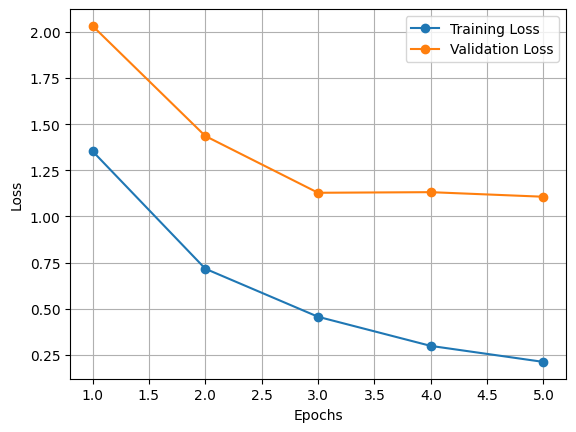

In [7]:
import matplotlib.pyplot as plt

# Example data
epochs = [1, 2, 3, 4, 5]
train_loss = list(training_loss.values())
val_loss = list(val_loss.values())

# Plotting
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
# plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

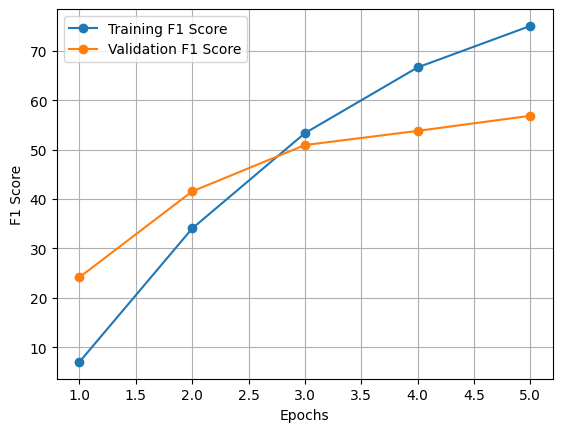

In [8]:
import matplotlib.pyplot as plt

# Example data
epochs = [1, 2, 3, 4, 5]
train_loss = list(training_f1.values())
val_loss = list(val_f1.values())

# Plotting
plt.plot(epochs, train_loss, label='Training F1 Score', marker='o')
plt.plot(epochs, val_loss, label='Validation F1 Score', marker='o')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
# plt.title('Training and Validation F1 Score')
plt.legend()
plt.grid(True)
plt.show()